In [2]:
import itertools
from pathlib import Path
from typing import List

import numpy as np
import pandas as pd
import plotly.express as px

from IPython.display import display, HTML
import plotly.graph_objects as go
from plotly.subplots import make_subplots

In [3]:
pd.set_option('display.max_rows', 20)
pd.set_option('display.max_columns', 50)
pd.set_option('display.width', 1000)

# Let's define some constants

datasets = [
    "kuhar",
    "motionsense",
    "uci",
    "wisdm",
    "realworld"
]


labels_activity = {
    0: "sit",
    1: "stand",
    2: "walk",
    3: "stair up",
    4: "stair down",
    5: "run",
    6: "stair up and down",
}

colors_map = {
    "plotly-blue": px.colors.qualitative.Plotly[0],
    "plotly-green": px.colors.qualitative.Plotly[2],
    "plotly-purple": px.colors.qualitative.Plotly[3],
    "plotly-orange": px.colors.qualitative.Plotly[4],
    "plotly-cyan": px.colors.qualitative.Plotly[5],
    "plotly-pink": px.colors.qualitative.Plotly[6],
    "plotly-lightgreen": px.colors.qualitative.Plotly[7],
    "plotly-lightpink": px.colors.qualitative.Plotly[8],
    "plotly-yellow": px.colors.qualitative.Plotly[9],
    "plotly-red": px.colors.qualitative.Plotly[1],
}

colors = list(colors_map.values())
markers = ["circle", "square", "diamond", "x", "triangle-up", "triangle-down", "pentagon"]

In [17]:
# Let's define some filters related to each of the columns

# --- Related to domain ---
def filter_domain_fft_only(df):
    return df[df["transforms"] == "fft"]

def filter_domain_time_only(df):
    return df.loc[df["transforms"] == "time"]


# --- Related to features ---
def filter_features_all(df):
    return df[
        df["in_use_features"].str.contains("accel-x")
        & df["in_use_features"].str.contains("accel-y")
        & df["in_use_features"].str.contains("accel-z")
        & df["in_use_features"].str.contains("gyro-x")
        & df["in_use_features"].str.contains("gyro-y")
        & df["in_use_features"].str.contains("gyro-z")
    ]

def filter_features_accelerometer_only(df):
    return df[
        df["in_use_features"].str.contains("accel-x")
        & df["in_use_features"].str.contains("accel-y")
        & df["in_use_features"].str.contains("accel-z")
        & ~df["in_use_features"].str.contains("gyro-x")
        & ~df["in_use_features"].str.contains("gyro-y")
        & ~df["in_use_features"].str.contains("gyro-z")
    ]

def filter_features_gyroscope_only(df):
    return df[
        ~df["in_use_features"].str.contains("accel-x")
        & ~df["in_use_features"].str.contains("accel-y")
        & ~df["in_use_features"].str.contains("accel-z")
        & df["in_use_features"].str.contains("gyro-x")
        & df["in_use_features"].str.contains("gyro-y")
        & df["in_use_features"].str.contains("gyro-z")
    ]

# --- Related to how reducer is executed ---
def filter_reducer_over_all(df):
    return df[df["reduce_on"] == "all"]

def filter_reducer_over_sensor(df):
    return df[df["reduce_on"] == "sensor"]

def filter_reducer_over_axis(df):
    return df[df["reduce_on"] == "axis"]

# --- Related to the estimator ---
def filter_estimator_rf(df):
    return df[df["estimator"].str.lower().str.contains("randomforest")]

def filter_estimator_svm(df):
    return df[df["estimator"].str.lower().str.contains("svm")]

def filter_estimator_knn(df):
    return df[df["estimator"].str.lower().str.contains("knn")]

# --- Related to the scaler ---
def filter_scaler_none(df):
    return df[df["scaler"] == "no scaler"]

def filter_scaler_minmax(df):
    return df[df["scaler"].str.lower().str.contains("minmaxscaler")]

def filter_scaler_std(df):
   return df[df["scaler"].str.lower().str.contains("standardscaler")]

# --- Related to the view ---
def filter_view_standardized_inter_balanced(df):
    return df[df["view"] == "standartized_intra_balanced"] # typo in the data intra -> inter

def filter_view_standardized_balanced(df):
    return df[df["view"] == "standartized"]

def filter_view_raw(df):
    return df[df["view"] == "raw_balanced"]    

# --- Some other useful filters ---
def filter_only_reducer_dataset_equals_train_dataset(df):
    return df[df["reducer_datasets"] == df["train_datasets"]]

def filter_only_reducer_dataset_equals_train_dataset_or_no_reducer(df):
    return df[(df["reducer_datasets"] == df["train_datasets"]) | (df["reducer_datasets"] == "")]

def filter_only_reducer_dataset_diferent_from_train(df):
    return df[(df["reducer_datasets"] != df["train_datasets"]) & (df["reducer_datasets"] != "")]

def filter_same_train_test(df):
    return df[df["train_datasets"] == df["test_datasets"]]

def filter_different_train_test(df):
    return df[df["train_datasets"] != df["test_datasets"]]

In [16]:
# Preprocessing steps
def rename_datasets(
    df, columns: List[str] = ("reducer_datasets", "train_datasets", "test_datasets")
):
    def rename_row(row):
        for col in columns:
            names = set()
            for name in row[col].split(","):
                name = name.strip()
                names.add(name.split(".")[0])
            row[col] = ", ".join(sorted(names))
        return row

    df = df.apply(rename_row, axis=1)
    return df

def add_view_name(df, new_column_name: str = "view"):
    df[new_column_name] = df["config_id"].apply(lambda x: "_".join(x.split("_")[:-1]))
    return df

def match_configs(df, new_column_name: str = "config_group"):
    group_no = 0
    for k, subdf in df.groupby(
        [
            "in_use_features",
            "scale_on",
            "reduce_on",
            "transforms",
            "scaler",
            "reducer",
            "umap components",
            "reducer_datasets",
            "train_datasets",
            "test_datasets",
            "estimator",
        ]
    ):
        if len(subdf) == 2:
            df.loc[subdf.index, new_column_name] = group_no
            group_no += 1
    return df

In [6]:
results_file = Path("results2.csv")
results = pd.read_csv(results_file).fillna("")
# Lets transform and add some useful information
results = rename_datasets(results)
results = add_view_name(results)
results = match_configs(results)
results

,experiment_name,run_name,config_id,reduce_size,train_size,test_size,in_use_features,scale_on,reduce_on,transforms,scaler,reducer,umap components,reducer_datasets,train_datasets,test_datasets,estimator,accuracy (mean),accuracy (std),f1-score macro (mean),f1-score macro (std),f1-score weighted (mean),f1-score weighted (std),view,config_group
0,reducer_comb_1,execution1,standartized_intra_balanced_03744,1794,1495,120,"gyro-x, gyro-y, gyro-z",train,sensor,,,umap-4,4,kuhar,wisdm,wisdm,randomforest-100,0.590000,1.779513e-02,0.589906,1.835340e-02,0.589906,1.835340e-02,standartized_intra_balanced,NaN
1,reducer_comb_1,execution1,standartized_intra_balanced_03744,1794,1495,120,"gyro-x, gyro-y, gyro-z",train,sensor,,,umap-4,4,kuhar,wisdm,wisdm,KNN-5,0.508333,1.110223e-16,0.490085,0.000000e+00,0.490085,0.000000e+00,standartized_intra_balanced,NaN
2,reducer_comb_1,execution1,standartized_intra_balanced_03744,1794,1495,120,"gyro-x, gyro-y, gyro-z",train,sensor,,,umap-4,4,kuhar,wisdm,wisdm,SVM-rbf-C1.0,0.475000,5.551115e-17,0.443587,0.000000e+00,0.443587,0.000000e+00,standartized_intra_balanced,NaN
3,reducer_comb_1,execution1,raw_balanced_00357,36258,36258,8694,"gyro-x, gyro-y, gyro-z",train,axis,,StandardScaler,umap-3,3,realworld,realworld,realworld,randomforest-100,0.524718,7.052341e-03,0.527988,6.879822e-03,0.527988,6.879822e-03,raw_balanced,NaN
4,reducer_comb_1,execution1,raw_balanced_00357,36258,36258,8694,"gyro-x, gyro-y, gyro-z",train,axis,,StandardScaler,umap-3,3,realworld,realworld,realworld,KNN-5,0.486657,5.551115e-17,0.486548,0.000000e+00,0.486548,0.000000e+00,raw_balanced,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
255019,reducer_comb_1_not_intra,execution1,standartized_balanced06046,3978,3978,1062,"accel-x, accel-y, accel-z",train,all,,MinMaxScaler,umap-60,60,motionsense,motionsense,motionsense,KNN-5,0.678908,1.110223e-16,0.667955,0.000000e+00,0.667955,0.000000e+00,standartized,NaN
255020,reducer_comb_1_not_intra,execution1,standartized_balanced06046,3978,3978,1062,"accel-x, accel-y, accel-z",train,all,,MinMaxScaler,umap-60,60,motionsense,motionsense,motionsense,SVM-rbf-C1.0,0.670433,0.000000e+00,0.660633,1.110223e-16,0.660633,1.110223e-16,standartized,NaN
255021,reducer_comb_1_not_intra,execution1,standartized_balanced00441,3978,3978,1062,"gyro-x, gyro-y, gyro-z",train,sensor,FFT-centered,,umap-3,3,motionsense,motionsense,motionsense,randomforest-100,0.846610,2.246113e-03,0.846194,2.225924e-03,0.846194,2.225924e-03,standartized,NaN
255022,reducer_comb_1_not_intra,execution1,standartized_balanced00441,3978,3978,1062,"gyro-x, gyro-y, gyro-z",train,sensor,FFT-centered,,umap-3,3,motionsense,motionsense,motionsense,KNN-5,0.837100,0.000000e+00,0.836378,1.110223e-16,0.836378,0.000000e+00,standartized,NaN


In [19]:
df = results.copy()
df = filter_view_standardized_inter_balanced(df)
sorted(df["umap components"].unique())

[2,
 3,
 4,
 5,
 6,
 7,
 8,
 9,
 10,
 15,
 18,
 20,
 21,
 24,
 27,
 30,
 33,
 36,
 42,
 48,
 54,
 60,
 900,
 1800]

In [6]:
results = results[
    ~(results["reducer_datasets"] == "")
    | (results["umap components"] == 0)
]
list(results.columns), results.shape

(['experiment_name',
  'run_name',
  'config_id',
  'reduce_size',
  'train_size',
  'test_size',
  'in_use_features',
  'scale_on',
  'reduce_on',
  'transforms',
  'scaler',
  'reducer',
  'umap components',
  'reducer_datasets',
  'train_datasets',
  'test_datasets',
  'estimator',
  'accuracy (mean)',
  'accuracy (std)',
  'f1-score macro (mean)',
  'f1-score macro (std)',
  'f1-score weighted (mean)',
  'f1-score weighted (std)',
  'view',
  'config_group'],
 (225054, 25))

In [7]:
# Lets filter out some reduntant lines
results = results[
    ~(results["reducer_datasets"] == "")
    | (results["umap components"] == 0)
]

# As we only use umap, we can drop the reducer column
results = results.drop(columns=["reducer"])

# As we only use TIME and FFT domains, lets rename the values "" of column transforms to "TIME"
# and "FFT" to "FFT"
results.loc[results["transforms"] == "", "transforms"] = "time" 
results.loc[results["transforms"] == "FFT-centered", "transforms"] = "fft"

# If no scaler is used, lets change the value from "" to "no scaler"
results.loc[results["scaler"] == "", "scaler"] = "no scaler"

# As scaler is only used for the train dataset, we can drop the column scale_on
results = results.drop(columns=["scale_on"])

# Lets drop some meta-columns that we will not use
results = results.drop(columns=["experiment_name", "run_name", "config_id", "reduce_size", "train_size", "test_size"])
list(results.columns), results.shape

(['in_use_features',
  'reduce_on',
  'transforms',
  'scaler',
  'umap components',
  'reducer_datasets',
  'train_datasets',
  'test_datasets',
  'estimator',
  'accuracy (mean)',
  'accuracy (std)',
  'f1-score macro (mean)',
  'f1-score macro (std)',
  'f1-score weighted (mean)',
  'f1-score weighted (std)',
  'view',
  'config_group'],
 (225054, 17))

In [9]:
results = results[~(results["train_datasets"].str.contains("realworld"))]
results = results[~(results["reducer_datasets"].str.contains("realworld"))]
results

,in_use_features,reduce_on,transforms,scaler,umap components,reducer_datasets,train_datasets,test_datasets,estimator,accuracy (mean),accuracy (std),f1-score macro (mean),f1-score macro (std),f1-score weighted (mean),f1-score weighted (std),view,config_group
0,"gyro-x, gyro-y, gyro-z",sensor,time,no scaler,4,kuhar,wisdm,wisdm,randomforest-100,0.590000,1.779513e-02,0.589906,1.835340e-02,0.589906,1.835340e-02,standartized_intra_balanced,NaN
1,"gyro-x, gyro-y, gyro-z",sensor,time,no scaler,4,kuhar,wisdm,wisdm,KNN-5,0.508333,1.110223e-16,0.490085,0.000000e+00,0.490085,0.000000e+00,standartized_intra_balanced,NaN
2,"gyro-x, gyro-y, gyro-z",sensor,time,no scaler,4,kuhar,wisdm,wisdm,SVM-rbf-C1.0,0.475000,5.551115e-17,0.443587,0.000000e+00,0.443587,0.000000e+00,standartized_intra_balanced,NaN
6,"accel-x, accel-y, accel-z",axis,fft,no scaler,20,motionsense,motionsense,motionsense,randomforest-100,0.873540,4.690173e-03,0.873424,4.649545e-03,0.873424,4.649545e-03,raw_balanced,NaN
7,"accel-x, accel-y, accel-z",axis,fft,no scaler,20,motionsense,motionsense,motionsense,KNN-5,0.843691,1.110223e-16,0.844248,0.000000e+00,0.844248,1.110223e-16,raw_balanced,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
255019,"accel-x, accel-y, accel-z",all,time,MinMaxScaler,60,motionsense,motionsense,motionsense,KNN-5,0.678908,1.110223e-16,0.667955,0.000000e+00,0.667955,0.000000e+00,standartized,NaN
255020,"accel-x, accel-y, accel-z",all,time,MinMaxScaler,60,motionsense,motionsense,motionsense,SVM-rbf-C1.0,0.670433,0.000000e+00,0.660633,1.110223e-16,0.660633,1.110223e-16,standartized,NaN
255021,"gyro-x, gyro-y, gyro-z",sensor,fft,no scaler,3,motionsense,motionsense,motionsense,randomforest-100,0.846610,2.246113e-03,0.846194,2.225924e-03,0.846194,2.225924e-03,standartized,NaN
255022,"gyro-x, gyro-y, gyro-z",sensor,fft,no scaler,3,motionsense,motionsense,motionsense,KNN-5,0.837100,0.000000e+00,0.836378,1.110223e-16,0.836378,0.000000e+00,standartized,NaN


In [10]:
# Grouping by this columns should result in only one row per group
# It is a unique tuple that describes each experiment
unique_exp_columns = [
    "in_use_features",
    "reduce_on",
    "transforms",
    "scaler",
    "umap components",
    "reducer_datasets",
    "train_datasets",
    "test_datasets",
    "estimator",
    "view",
]

lines = []
for k, subdf in results.groupby(unique_exp_columns):
    lines.append(subdf.iloc[0])
results = pd.DataFrame(lines)

# Sanity check
results.groupby(unique_exp_columns).apply(lambda x: len(x) == 1).value_counts()

True    134955
dtype: int64

In [ ]:
def best_of_each_estimator(df):
    experiment_uniq = [c for c in unique_exp_columns if c not in ["estimator"]]

    best_of_each_dataset = []
    for key, subdf in df.groupby(experiment_uniq):
        best = subdf.sort_values(by="accuracy (mean)", ascending=False, inplace=False).iloc[0]
        best_of_each_dataset.append(best)
    return pd.DataFrame(best_of_each_dataset)

def best_of_each_umap(df):
    experiment_uniq = [c for c in unique_exp_columns if c not in ["umap components"]]

    best_of_each_dataset = []
    for key, subdf in df.groupby(experiment_uniq):
        best = subdf.sort_values(by="accuracy (mean)", ascending=False, inplace=False).iloc[0]
        best_of_each_dataset.append(best)
    return pd.DataFrame(best_of_each_dataset)

def best_of_each_estimator_and_umap(df):
    experiment_uniq = [c for c in unique_exp_columns if c not in ["estimator", "umap components"]]

    best_of_each_dataset = []
    for key, subdf in df.groupby(experiment_uniq):
        best = subdf.sort_values(by="accuracy (mean)", ascending=False, inplace=False).iloc[0]
        best_of_each_dataset.append(best)
    return pd.DataFrame(best_of_each_dataset)

In [11]:
def chart_bar_with_error_bars(df, improvement_col: str, groupby: str = "train_datasets"):
    xs, ys, error_y_min, error_y_max = [], [], [], []
    for key, subdf in df.groupby(groupby):
        sorted_improvement = sorted(subdf[improvement_col].values)
        # print(sorted_improvement)
        xs.append(key)
        ys.append(sorted_improvement[1])
        error_y_min.append(abs(sorted_improvement[0]-sorted_improvement[1]))
        error_y_max.append(abs(sorted_improvement[-1]-sorted_improvement[1]))

    fig = go.Figure()
    fig.add_trace(
        go.Bar(
            x=xs,
            y=ys,
            error_y=dict(
                type="data",
                symmetric=False,
                array=error_y_max,
                arrayminus=error_y_min
            )
        )
    )
    return fig

def chart_bar_with_side_by_side(df, improvement_col: str, groupby: str = "train_datasets", inner_group: str = "estimator"):
    fig = go.Figure()

    for i, (key, subdf) in enumerate(df.groupby(groupby)):
        xs, ys = [], []
        for inner_key, inner_subdf in subdf.groupby(inner_group):
            xs.append(str(inner_key))
            ys.append(inner_subdf[improvement_col].values[0])
        
        fig.add_trace(
            go.Bar(
                y=ys,
                x=xs,
                name=str(key),
                marker=dict(color=colors[i])
            )
        )
    return fig

## Pergunta 1

### a) Qual o impacto no desempenho dos modelos de ML quando o dado de entrada é transformado com o UMAP?

Compararemos, para cada tupla <dataset DS; domíno D; modelo de ML M>, qual é a diferença (razão) de desempenho do modelo M na tarefa de HAR com o dado do dataset DS no domínio D com e sem redução de dimensionalidade.

In [20]:
def get_umap_improvement_over_no_umap(df, new_column_name: str = "umap improvement"):
    experiment_uniq = [c for c in unique_exp_columns if c not in ["reducer_datasets", "umap components"]]

    zero_umap = {}
    for _, subdf in df[df["umap components"] == 0].iterrows():
        zero_umap[tuple(subdf[experiment_uniq].values.tolist())] = subdf["accuracy (mean)"]

    df[new_column_name] = df.apply(lambda x: x["accuracy (mean)"] / zero_umap.get(tuple(x[experiment_uniq].values.tolist()), np.nan), axis=1)
    return df

def filter_max_set_only(df, column: str = "umap improvement"):
    experiment_uniq = [c for c in unique_exp_columns if c not in ["reducer_datasets", "umap components"]]
    df = df.dropna(subset=[column], inplace=False)
    df = df[df["umap components"] > 0]
    lines = [subdf[subdf[column] == subdf[column].max()].iloc[0] for _, subdf in df.groupby(experiment_uniq)]
    df = pd.DataFrame(lines)
    return df

df = results.copy()
df = filter_view_standardized_inter_balanced(df)
df = filter_domain_fft_only(df)
df = filter_features_all(df)
df = filter_reducer_over_all(df)
df = filter_scaler_none(df)
df = filter_only_reducer_dataset_equals_train_dataset_or_no_reducer(df)
df = get_umap_improvement_over_no_umap(df)
df = filter_max_set_only(df)

fig = chart_bar_with_error_bars(df, improvement_col="umap improvement", groupby="train_datasets")
fig.add_hline(y=1.0, line_dash="dash", line_color="magenta")
fig.update_layout(
    title="UMAP Improvement for each dataset (best UMAP over no UMAP, per dataset).<br>Error bars comes from different estimators",
    xaxis_title="Dataset",
    yaxis_title="Accuracy Improvement over no UMAP",
    width=800,
    height=600
)
fig.show()

fig = chart_bar_with_side_by_side(df, improvement_col="umap improvement", groupby="estimator", inner_group="train_datasets")
fig.add_hline(y=1.0, line_dash="dash", line_color="red")
fig.update_layout(
    title="UMAP Improvement for each dataset (best UMAP over no UMAP, per dataset)",
    xaxis_title="Dataset",
    yaxis_title="Accuracy Improvement over no UMAP",
    legend_title="Estimator",
    width=800,
    height=600
)
fig.show()

### b) Qual é o impacto da dimensionalidade alvo do UMAP no desempenho dos modelos de ML?

b .1) UMAP vs No-UMAP

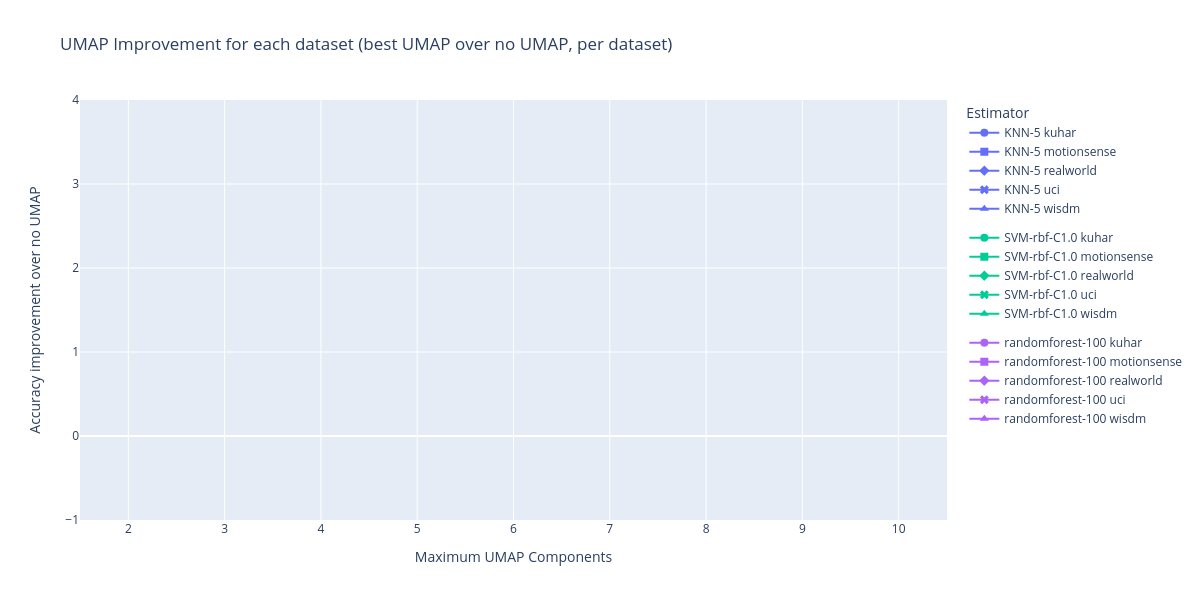

In [18]:
df = results.copy()
df = filter_domain_fft_only(df)
df = filter_features_all(df)
df = filter_reducer_over_all(df)
df = filter_scaler_none(df)
df = filter_view_standardized_balanced(df)
df = filter_only_reducer_dataset_equals_train_dataset_or_no_reducer(df)
df = get_umap_improvement_over_no_umap(df)
df = df[(df["umap components"] > 0) & (df["umap components"] <= 10)]
df


dset_markers = {
    name: markers[i]
    for i, name in enumerate(df["train_datasets"].unique())
}

estimator_colors = {
    name: colors[i]
    for i, name in enumerate(df["estimator"].unique())
}

fig = go.Figure()
for (estimator, dataset), subdf in df.groupby(["estimator", "train_datasets"]):
    subdf = subdf.sort_values(by="umap components")
    xs, ys = [], []
    for n_components in sorted(subdf["umap components"].unique()):
        xs.append(n_components)
        ys.append(subdf[subdf["umap components"] <= n_components]["umap improvement"].max())
    fig.add_trace(
        go.Scatter( 
            x=xs,
            y=ys,
            name=f"{estimator} {dataset}",
            mode="lines+markers",
            legendgroup=estimator,
            # legendgrouptitle="Estimator",
            marker=dict(
                color=estimator_colors[estimator],
                symbol=dset_markers[dataset],
                size=8,
            ),
        )
    )
    # subdf["best umap improvement so far"] = df["umap improvement"].expanding().max()

fig.update_layout(
    title="UMAP Improvement for each dataset (best UMAP over no UMAP, per dataset)",
    xaxis_title="Maximum UMAP Components",
    yaxis_title="Accuracy improvement over no UMAP",
    legend_title="Estimator",
    width=1200,
    height=600,
    # xaxis=dict(tickmode="linear")
)
fig.show("png")

b.2) UMAP vs best UMAP

In [21]:
def get_umap_improvement_over_best_umap(df, new_column_name: str = "umap improvement"):
    df = df[df["umap components"] != 0]
    experiment_uniq = [c for c in unique_exp_columns if c not in ["reducer_datasets", "umap components"]]

    best_umap = {}
    for key, subdf in df.groupby(experiment_uniq):
        best_umap[key] = subdf["accuracy (mean)"].max()

    for key, subdf in df.groupby(experiment_uniq):
        df.loc[subdf.index, new_column_name] = subdf["accuracy (mean)"] / best_umap[key]

    return df

In [22]:
df = results.copy()
df = filter_domain_fft_only(df)
df = filter_features_all(df)
df = filter_reducer_over_all(df)
df = filter_scaler_none(df)
df = filter_view_standardized_balanced(df)
df = filter_only_reducer_dataset_equals_train_dataset_or_no_reducer(df)
df = get_umap_improvement_over_best_umap(df)
# df = df[(df["umap components"] > 0) & (df["umap components"] <= 200)]

dset_markers = {
    name: markers[i]
    for i, name in enumerate(df["train_datasets"].unique())
}

estimator_colors = {
    name: colors[i]
    for i, name in enumerate(df["estimator"].unique())
}

fig = go.Figure()
for (estimator, dataset), subdf in df.groupby(["estimator", "train_datasets"]):
    subdf = subdf.sort_values(by="umap components")
    xs, ys = [], []
    for n_components in sorted(subdf["umap components"].unique()):
        xs.append(n_components)
        ys.append(subdf[subdf["umap components"] <= n_components]["umap improvement"].max())
    fig.add_trace(
        go.Scatter( 
            x=xs,
            y=ys,
            name=f"{estimator} {dataset}",
            mode="lines+markers",
            legendgroup=estimator,
            # legendgrouptitle="Estimator",
            marker=dict(
                color=estimator_colors[estimator],
                symbol=dset_markers[dataset],
                size=7,
            ),
        )
    )
    # subdf["best umap improvement so far"] = df["umap improvement"].expanding().max()

fig.update_layout(
    title="UMAP Improvement for each dataset (UMAP over best UMAP, per dataset)",
    xaxis_title="Maximum UMAP Components",
    yaxis_title="Accuracy improvement best UMAP",
    legend_title="Estimator",
    width=1200,
    height=600,
    # xaxis=dict(tickmode="linear")
)
fig.show()

### Pergunta 1.c

In [28]:
experiment_uniq = [c for c in unique_exp_columns if c not in ["train_datasets", "view"]]

df = results.copy()
df = filter_domain_fft_only(df)
df = filter_features_all(df)
df = filter_reducer_over_all(df)
df = filter_scaler_none(df)
df = filter_only_reducer_dataset_equals_train_dataset_or_no_reducer(df)

fig = go.Figure()


for i, (dset_name, train_df) in enumerate(df.groupby(["train_datasets"])):
    xs, ys = [], []
    for j, (view_name, subdf) in enumerate(train_df.groupby("view")):
        umap_0_max = subdf[subdf["umap components"] == 0]["accuracy (mean)"].max()
        xs.append(f"{dset_name} {view_name.split('_')[0]} (no umap)")
        ys.append(umap_0_max)
    
    fig.add_trace(
        go.Bar(
            x=xs,
            y=ys,
            name=f"{dset_name} no umap",
            marker=dict(color=colors[0]),
            legendgroup="no umap",
        )
    )
    xs, ys = [], []
    for j, (view_name, subdf) in enumerate(train_df.groupby("view")):
        umap_best_max = subdf[subdf["umap components"] > 0]["accuracy (mean)"].max()
        xs.append(f"{dset_name} {view_name.split('_')[0]} (best umap)")
        ys.append(umap_best_max)
    
    fig.add_trace(
        go.Bar(
            x=xs,
            y=ys,
            name=f"{dset_name} best umap",
            marker=dict(color=colors[1]),
            legendgroup="best umap",
        )
    )

fig.update_layout(
    title="Impact of standardization process on UMAP",
    xaxis_title="Dataset view",
    yaxis_title="Accuracy of best UMAP and best classifier",
    legend_title="Estimator",
    width=1200,
    height=800,
    xaxis=dict(tickangle=90)
)

# fig.update_xaxes(tickangle=75)
fig.show()

/tmp/ipykernel_233155/862335259.py:13: FutureWarning:

In a future version of pandas, a length 1 tuple will be returned when iterating over a groupby with a grouper equal to a list of length 1. Don't supply a list with a single grouper to avoid this warning.



## Pergunta 2

Como a escolha do dataset no treinamento do UMAP afeta os resultados da tarefa?

- Normalizar pelo melhor do dataset de teste
- Marcador por dataset
- Comparar MAE

In [29]:
df = results.copy()
df = filter_domain_fft_only(df)
df = filter_features_all(df)
df = filter_reducer_over_all(df)
df = filter_scaler_none(df)
df = filter_view_standardized_inter_balanced(df)
# df = pd.concat([filter_only_reducer_dataset_diferent_from_train(df), filter_only_reducer_dataset_equals_train_dataset(df)])
df = filter_only_reducer_dataset_diferent_from_train(df)
df = filter_same_train_test(df)
df = best_of_each_estimator(df)

marker_colors = list(itertools.product(markers, colors))

fig = go.Figure()

for i, n_components in enumerate(sorted(df["umap components"].unique())):
    df_comp = df[df["umap components"] == n_components]
    # df_comp = best_of_each_estimator(df_comp)
    df_comp.sort_values(by="accuracy (mean)", inplace=True)
    fig.add_trace(
        go.Scatter(
            x=list(range(len(df_comp))),
            y=df_comp["accuracy (mean)"],
            name=f"UMAP {n_components} components",
            mode="lines+markers",
            marker=dict(
                color=marker_colors[i][1],
                symbol=marker_colors[i][0],
                size=7,
            ),
        )
    )

fig.update_layout(
    title="FFT",
    xaxis_title="Number of experiments",
    yaxis_title="Accuracy (best estimator only)",
    legend_title="UMAP Components",
    width=1200,
    height=600,
    yaxis=dict(range=[0, 1]),
    # xaxis=dict(tickmode="linear")
)
fig.show()

/tmp/ipykernel_233155/3671092761.py:19: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [25]:
df = results.copy()
df = filter_domain_time_only(df)
df = filter_features_all(df)
df = filter_reducer_over_all(df)
df = filter_scaler_none(df)
df = filter_view_standardized_inter_balanced(df)
# df = pd.concat([filter_only_reducer_dataset_diferent_from_train(df), filter_only_reducer_dataset_equals_train_dataset(df)])
df = filter_only_reducer_dataset_diferent_from_train(df)
df = filter_same_train_test(df)
df = best_of_each_estimator(df)

marker_colors = list(itertools.product(markers, colors))

fig = go.Figure()

for i, n_components in enumerate(sorted(df["umap components"].unique())):
    df_comp = df[df["umap components"] == n_components]
    # df_comp = best_of_each_estimator(df_comp)
    df_comp.sort_values(by="accuracy (mean)", inplace=True)
    fig.add_trace(
        go.Scatter(
            x=list(range(len(df_comp))),
            y=df_comp["accuracy (mean)"],
            name=f"UMAP {n_components} components",
            mode="lines+markers",
            marker=dict(
                color=marker_colors[i][1],
                symbol=marker_colors[i][0],
                size=7,
            ),
        )
    )

fig.update_layout(
    title="Time",
    xaxis_title="Number of experiments",
    yaxis_title="Accuracy (best estimator only)",
    legend_title="UMAP Components",
    width=1200,
    height=600,
    yaxis=dict(range=[0, 1]),
    # xaxis=dict(tickmode="linear")
)
fig.show()

/tmp/ipykernel_490130/2338358819.py:19: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



## Pergunta 3

## Pergunta 4

## Pergunta 5

É mais vantajoso reduzir a dimensionalidade dos dados dos sensores de forma individual (aplicando o UMAP a um sensor, ou eixo, por vez) ou de forma agregada (como estamos fazendo)?

In [26]:
def get_reduce_on_improvement(df):
    experiment_uniq = [c for c in unique_exp_columns if c not in ["reduce_on", "umap components"]]

    all_values = {}
    for _, subdf in df[df["reduce_on"] == "all"].iterrows():
        all_values[tuple(subdf[experiment_uniq].values.tolist())] = subdf["accuracy (mean)"]

    df["umap improvement"] = df.apply(lambda x: x["accuracy (mean)"] / all_values.get(tuple(x[experiment_uniq].values.tolist()), np.nan), axis=1)
    df = df.dropna(subset=["umap improvement"], inplace=False)
    df = df[df["reduce_on"] != "all"]
    lines = [subdf[subdf["umap improvement"] == subdf["umap improvement"].max()].iloc[0] for _, subdf in df.groupby(experiment_uniq)]
    df = pd.DataFrame(lines)
    return df

# results = add_umap_improvement(results)
#df = only_standardized_view(no_scaler(using_all_features(only_fft(only_reduce_on_all(only_reducer_equals_train(df))))))

In [37]:
df = results.copy()
df = filter_domain_fft_only(df)
df = filter_features_all(df)
# df = filter_reducer_over_all(df)
df = filter_scaler_none(df)
df = filter_view_standardized_balanced(df)
df = best_of_each_umap(df)
df = filter_only_reducer_dataset_equals_train_dataset(df)
df = get_reduce_on_improvement(df)


fig = chart_bar_with_side_by_side(df, improvement_col="umap improvement", groupby="estimator", inner_group=["train_datasets", "reduce_on"])
fig.update_layout(
    title="Improvement using multiple UMAPs to train per sensor and per axis over using all axis of all sensors",
    xaxis_title="reduce_on / dataset",
    yaxis_title="Improvement over using all axis of all sensors (best UMAP)",
    legend_title="Estimator",
    width=1200,
    height=600
)
fig.show()


In [36]:
df = results.copy()
df = filter_domain_fft_only(df)
df = filter_features_all(df)
# df = filter_reducer_over_all(df)
df = filter_scaler_none(df)
df = filter_view_standardized_balanced(df)
df = best_of_each_estimator(df)
df = filter_only_reducer_dataset_equals_train_dataset(df)
# df = get_reduce_on_improvement(df)

names = []

fig = make_subplots(rows=1, cols=3, shared_yaxes=True)
for i, (reduce_on, subdf) in enumerate(df.groupby("reduce_on")):
    for j, (dataset_name, subsubdf) in enumerate(subdf.groupby("train_datasets")):
        subsubdf = subsubdf.sort_values(by="umap components", inplace=False)
        fig.add_trace(
            go.Scatter(
                x=subsubdf["umap components"],
                y=subsubdf["accuracy (mean)"],
                name=dataset_name,
                mode="lines+markers",
                marker=dict(color=colors[j]),
            ),
            row=1, col=i+1
        )
    names.append(reduce_on)

fig["layout"]["xaxis1"].update(title=f"UMAP components ({names[0]})", tickmode="linear")
fig["layout"]["xaxis2"].update(title=f"UMAP components ({names[1]})", tickmode="linear")
fig["layout"]["xaxis3"].update(title=f"UMAP components ({names[2]})", tickmode="linear")
fig["layout"]["yaxis1"].update(title="Accuracy (mean)", range=[0.5, 1])
fig["layout"]["yaxis1"].update(range=[0.5, 1])
fig["layout"]["yaxis1"].update(range=[0.5, 1])
fig.update_layout(
    title="UMAP applied to train per sensor and per axis and using all features",
    width=1200,
    height=600,
    legend_title="Dataset",
    showlegend=False,
    # xaxis=dict(tickmode="linear"),
    yaxis=dict(range=[0, 1])

)
    
fig.show("png")

KeyboardInterrupt: 

## Pergunta 6

Há uma mudança significativa entre os diferentes classificadores?

In [20]:
# def get_estimator_improvement(df):
#     experiment_uniq = [c for c in unique_exp_columns if c not in ["estimator"]]
#     df = df[df["umap components"] > 0]

#     all_values = {}
#     for _, subdf in df[df["reduce_on"] == "all"].iterrows():
#         all_values[tuple(subdf[experiment_uniq].values.tolist())] = subdf["accuracy (mean)"]

#     df["umap improvement"] = df.apply(lambda x: x["accuracy (mean)"] / all_values.get(tuple(x[experiment_uniq].values.tolist()), np.nan), axis=1)
#     df = df.dropna(subset=["umap improvement"], inplace=False)
#     df = df[df["reduce_on"] != "all"]
#     lines = [subdf[subdf["umap improvement"] == subdf["umap improvement"].max()].iloc[0] for _, subdf in df.groupby(experiment_uniq)]
#     df = pd.DataFrame(lines)
#     return df

# # results = add_umap_improvement(results)
# #df = only_standardized_view(no_scaler(using_all_features(only_fft(only_reduce_on_all(only_reducer_equals_train(df))))))

## Pergunta 7

Melhor no domínio da frequência ou tempo (condicionada à abordagem - manifold learning com UMAP)? (ou wavelet?)

- Usar barras de sobreposição
- Sem UMAP (tempo e frequencia)
- Best(<20) vs UMAP 10

In [35]:
df = results.copy()
df = filter_domain_fft_only(df)
df = filter_features_all(df)
df = filter_reducer_over_all(df)
df = filter_scaler_none(df)
df = filter_view_standardized_balanced(df)
df = filter_only_reducer_dataset_equals_train_dataset_or_no_reducer(df)
# df = get_umap_improvement_over_no_umap(df)
df = best_of_each_umap(df)

fig = chart_bar_with_side_by_side(df, improvement_col="accuracy (mean)", groupby="estimator", inner_group="train_datasets")
# fig.add_hline(y=1.0, line_dash="dash", line_color="magenta")
fig.update_layout(
    title="Accuracy using FFT",
    xaxis_title="Dataset",
    yaxis_title="Accuracy (mean)",
    legend_title="Estimator",
    width=800,
    height=600
)
fig.show()

In [36]:
df = results.copy()
df = filter_domain_time_only(df)
df = filter_features_all(df)
df = filter_reducer_over_all(df)
df = filter_scaler_none(df)
df = filter_view_standardized_balanced(df)
df = filter_only_reducer_dataset_equals_train_dataset_or_no_reducer(df)
# df = get_umap_improvement_over_no_umap(df)
df = best_of_each_umap(df)

fig = chart_bar_with_side_by_side(df, improvement_col="accuracy (mean)", groupby="estimator", inner_group="train_datasets")
# fig.add_hline(y=1.0, line_dash="dash", line_color="magenta")
fig.update_layout(
    title="Accuracy using TIME",
    xaxis_title="Dataset",
    yaxis_title="Accuracy (mean)",
    legend_title="Estimator",
    width=800,
    height=600
)
fig.show()

## Pergunta 8

## Pergunta 9

Normalização traz mais benefícios?

In [38]:
def get_scaler_improvement(df):
    experiment_uniq = [c for c in unique_exp_columns if c not in ["scaler"]]

    all_values = {}
    for _, subdf in df[df["scaler"] == "no scaler"].iterrows():
        all_values[tuple(subdf[experiment_uniq].values.tolist())] = subdf["accuracy (mean)"]

    df["umap improvement"] = df.apply(lambda x: x["accuracy (mean)"] / all_values.get(tuple(x[experiment_uniq].values.tolist()), np.nan), axis=1)
    df = df.dropna(subset=["umap improvement"], inplace=False)
    df = df[df["scaler"] != "no scaler"]
    lines = [subdf[subdf["umap improvement"] == subdf["umap improvement"].max()].iloc[0] for _, subdf in df.groupby(experiment_uniq)]
    df = pd.DataFrame(lines)
    return df

In [39]:
df = results.copy()
df = filter_domain_fft_only(df)
df = filter_features_all(df)
df = filter_reducer_over_all(df)
# df = filter_scaler_none(df)
df = filter_view_standardized_balanced(df)
# df = best_of_each_umap(df)
df = filter_only_reducer_dataset_equals_train_dataset(df)
df = get_scaler_improvement(df)

fig = chart_bar_with_side_by_side(df, improvement_col="umap improvement", groupby="estimator", inner_group=["train_datasets", "scaler"])
fig.add_hline(y=1.0, line_dash="dash", line_color="red")
fig.update_layout(
    title="Improvement using different scalers",
    xaxis_title="dataset / scaler",
    yaxis_title="Improvement over using no scaler",
    legend_title="Estimator",
    width=1200,
    height=600
)
fig.show()


## Pergunta 10

Quais os sensores que ajudam mais: acelerômetro, giroscópio, ambos?


In [40]:
def get_in_use_features_improvement(df):
    experiment_uniq = [c for c in unique_exp_columns if c not in ["in_use_features"]]

    all_values = {}
    for _, subdf in df[(df["in_use_features"].str.contains("accel-x")) & (df["in_use_features"].str.contains("gyro-x"))  ].iterrows():
        all_values[tuple(subdf[experiment_uniq].values.tolist())] = subdf["accuracy (mean)"]

    df["umap improvement"] = df.apply(lambda x: x["accuracy (mean)"] / all_values.get(tuple(x[experiment_uniq].values.tolist()), np.nan), axis=1)
    df = df.dropna(subset=["umap improvement"], inplace=False)
    df = df.loc[
        ~(df["in_use_features"].str.contains("accel-y")
        & df["in_use_features"].str.contains("accel-z")
        & df["in_use_features"].str.contains("gyro-x")
        & df["in_use_features"].str.contains("gyro-y")
        & df["in_use_features"].str.contains("gyro-z"))
    ]
    lines = [subdf[subdf["umap improvement"] == subdf["umap improvement"].max()].iloc[0] for _, subdf in df.groupby(experiment_uniq)]
    df = pd.DataFrame(lines)
    return df

In [41]:
df = results.copy()
df = filter_domain_fft_only(df)
# df = filter_features_all(df)
df = filter_reducer_over_all(df)
df = filter_scaler_none(df)
df = filter_view_standardized_balanced(df)
# df = best_of_each_umap(df)
df = filter_only_reducer_dataset_equals_train_dataset(df)
df = get_in_use_features_improvement(df)

fig = chart_bar_with_side_by_side(df, improvement_col="umap improvement", groupby="estimator", inner_group=["train_datasets", "in_use_features"])
fig.add_hline(y=1.0, line_dash="dash", line_color="red")
fig.update_layout(
    title="Improvement using different features",
    xaxis_title="dataset /  features",
    yaxis_title="Improvement over using all features",
    legend_title="Estimator",
    width=1200,
    height=600
)
fig.show()